# Experiment on a real dataset

This notebook follows the reproduction of the paper's experiment. Here, we apply the Sinkhirn kernel on a real dataset provided [by Safran here](https://plaid-lib.readthedocs.io/en/latest/source/data_challenges/rotor37.html). The data is composed of 3D modelisations of motor blades. Those blades are represented by a cloud points. 

The goal of this notebook is to perform regression task with X variable being the cloud points of the blade (one cloud point = 1 blade = 1 observation) and the target variable Y is a aerodynamic coefficient provided with the metadata of the blade. 
- We are going to carry this task using the Sinkhorn kernel of our [paper of interest](https://doi.org/10.48550/arXiv.2210.06574). 
- After that, we aim at using other kernel to carry out Kernel Ridge Regression, namely the Wassestein kernel and the Sliced Wasserstein kernel, and compare accuracy and computation efficiency of those different methods against the Sinkhorn kernel. 
- If time allows, the goal is to perform this regression task using Gaussian Processes, again with multiple kernels.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

# Importing the data
In this section we provide the code to import and view the data.

## Import packages

In [2]:
## Needed to import the data
import h5py
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading and importing the data

In [3]:
## Define functions to explore the .cgns file
def explore_cgns_structure(file_path):
    with h5py.File(file_path, 'r') as f:
        print("File structure:")
        explore_group(f)

def explore_group(group, indent=""):
    for key in group.keys():
        print(f"{indent}{key}")
        if isinstance(group[key], h5py.Group):
            explore_group(group[key], indent + "  ")


## Explore the veyy first blade .cgns file
number = '000000001'
explore_cgns_structure(f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns')

File structure:
 format
 hdf5version
Base_2_3
   data
  Time
     data
    IterationValues
       data
    TimeValues
       data
  Zone
     data
    ZoneType
       data
    GridCoordinates
      CoordinateX
         data
      CoordinateY
         data
      CoordinateZ
         data
    Elem_Quads
       data
      ElementRange
         data
      ElementConnectivity
         data
    VertexFields
      GridLocation
         data
      Density
         data
      Pressure
         data
      Temperature
         data
      NormalsX
         data
      NormalsY
         data
      NormalsZ
         data
    CellCenterFields
      GridLocation
         data
      Density
         data
      Pressure
         data
      Temperature
         data
      NormalsX
         data
      NormalsY
         data
      NormalsZ
         data
CGNSLibraryVersion
   data


We are interested in the coordonates of the cloud points. Lets define a function that can retrieve a cloud points from a .cgns file and the associated aero coefficient.

In [4]:
def read_cgns_coordinates(file_path):
    with h5py.File(file_path, 'r') as file:
        # We retrieve coordinate by coordinate.
        # ! Notice the space before the data. This is due to the naming in the files themselves.
        x = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateX'].get(' data'))
        y = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateY'].get(' data'))
        z = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateZ'].get(' data'))

    return x, y, z

Now we can import any number of blades with their aerodynamic coefficients.

In [5]:
## Number of blade one want to consider.
_many_blades = 10

## Creating the list of all file numbers.
padded_numbers = [str(i).zfill(9) for i in range(_many_blades)]

## Lists that will holds the cloud points and the associated efficiency.
distributions = []
efficiency = []

for number in padded_numbers:
    ## File paths
    #cgns_file_path = f'/content/drive/MyDrive/Developer/EnsaiCourses/Semestre_6/StatProject/Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    #coefficient_file_path = f'/content/drive/MyDrive/Developer/EnsaiCourses/Semestre_6/StatProject/Rotor37/dataset/samples/sample_{number}/scalars.csv'
    #cgns_file_path = f'/Users/louis/Library/CloudStorage/GoogleDrive-louis.allain@gmail.com/My Drive/Developer/EnsaiCourses/Semestre_6/StatProject/Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    #coefficient_file_path = f'/Users/louis/Library/CloudStorage/GoogleDrive-louis.allain@gmail.com/My Drive/Developer/EnsaiCourses/Semestre_6/StatProject/Rotor37/dataset/samples/sample_{number}/scalars.csv'
    cgns_file_path = f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    coefficient_file_path = f'Rotor37/dataset/samples/sample_{number}/scalars.csv'

    ## Computing the coordinates
    x, y, z = read_cgns_coordinates(cgns_file_path)
    blade = np.column_stack((x, y, z))

    ## Computing the coefficient
    scalars = pd.read_csv(coefficient_file_path)
    
    ## Adding to our data
    distributions.append(blade)
    efficiency.append(scalars["Efficiency"][0])

## Plotting blades

### Static plot

In [ ]:
plt.figure()
# Create a DataFrame for Seaborn (not necessary for this example)
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Create 3D scatter plot with Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, s=50, c='blue', marker='o')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the plot
plt.show()

### Dynamic plot



In [ ]:
plt.figure()
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=8, color='blue'))])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# To export the plot
fig.write_html("blade_plotly_figure.html")

# Show the plot
fig.show()

# Using the Sinkhorn kernel to perform Kernel Ridge Regression

The **first** problem that arises is the computation time. Each blade is made of about $30,000$ points. Performing Regularized Optimal Transport on such a big distribution's sample is long. Moreover, the function used in the toy experiment previoulsy uses the ```clouds_to_dual_sinkhorn``` function to perform ROT between two cloud points. This function uses a ```jax.vmap``` to perform the computation. Unfortunately this function has a very high usage of memory (which is needed to perform the computations in parallel) and is therefore not viable for our problem's size. Multiple solutions to bypass this issue:
1) Undersample every blade. Instead of a blade being $30,000$, we randomly select a portion of those points.
2) Undersample the training set. Instead of using the full $1,200$ blades we consider only a fraction of that.
3) Changing the way the computation is done. ```jax.vmap``` is very time effective. We could sacrifice time for memory, for instance by computing the ROT sequentially rather than parallely.

The **second** question is *which reference measure to consider ?* Again multiple ideas come to mind:
1) Using the first blade as the reference measure.
2) Taking the smallest rectangle in which all the blades fit and sampling points on its borders.
3) Taking random points in approximately a good range?

Many questions are still un-answered:
1) How many points should make the reference measure ?
2) For points 3., what should be the variance of the distribution ?

## Regularized Optimal Transport between two blades

This section is dedicated to perform ROT between two cloud points. It is mainly here to help us understand every steps needed to perform ROT using ```jax``` and ```ott``` packages. From here we will determine the best way to carry the ROT problem between two large samples, trading off between memory and time.

In [6]:
# Jax package allows to speed up computation
import jax.numpy as jnp

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn
import ott


# Start a timer
import time
start_time = time.time()


## First les take two first blade
blade_one = distributions[1]
blade_two = distributions[2]

## How many points per blade ?
size_cloud_points = len(blade_one)

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_two = jnp.array(blade_two)

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1

## Create PointCloud object to accomodate OTT package
my_geom = PointCloud(x = cloud_one, # training cloud
                  y = cloud_two, # reference cloud
                  epsilon = epsilon # epsilon of ROT
                  )

## Formalises the Regularized Optimal Transport problem
ot_problem = LinearProblem(geom = my_geom, # The geometry of the problem between the training data and the refrence measure
                           #weight, # Weight of the specific data
                           #mu_cloud.weights # Weight of the reference measure
                           )

## Instanciate the solver of the ROT problem
sinkhorn_solver =  Sinkhorn()

## Actually computing the Sinkhorn algortihm
rot_result = sinkhorn_solver(ot_problem)

## Retrieve left and right potentials
left_potentials = sinkhorn_solver(ot_problem).f
right_potentials = sinkhorn_solver(ot_problem).g

# Stops
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)

## Retrieve the transport map
transport_map = rot_result.to_dual_potentials().transport(cloud_one)

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

Regularized Optimal Transport computation took:  196.30931091308594 
Using epsilon =  1


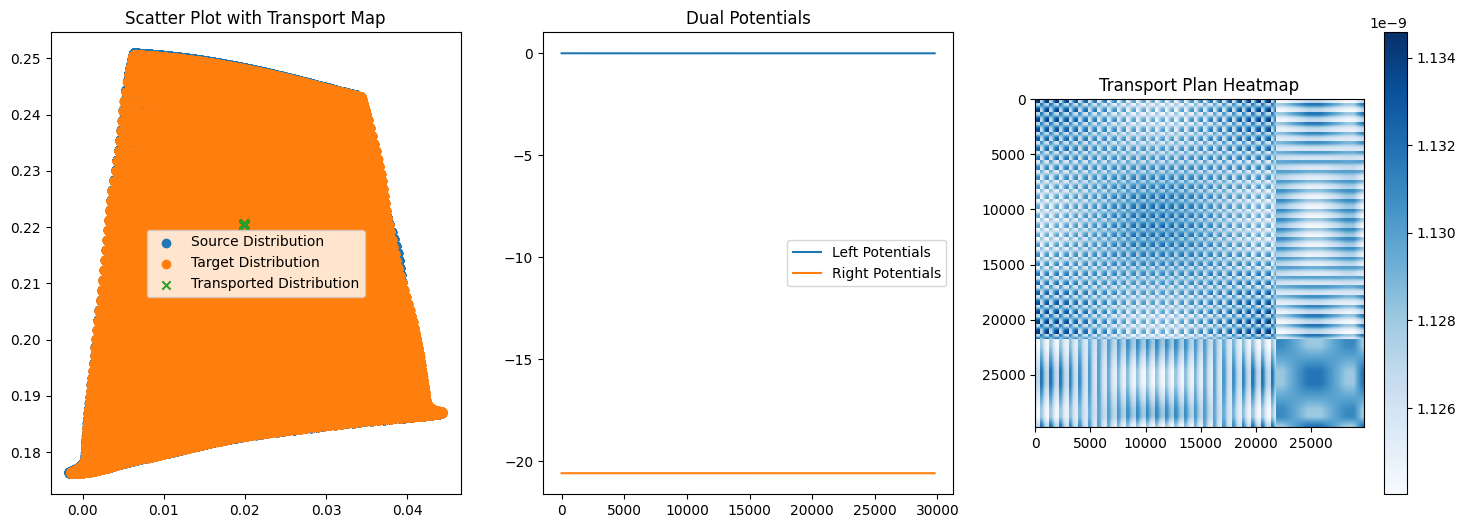

In [7]:
# Plotting the results
plt.figure(figsize=(18, 6))

# Scatter plot with transport map
plt.subplot(1, 3, 1)
plt.scatter(cloud_one[:, 0], cloud_one[:, 1], label='Source Distribution')
plt.scatter(cloud_two[:, 0], cloud_two[:, 1], label='Target Distribution')
plt.scatter(transport_map[:, 0], transport_map[:, 1], label='Transported Distribution', marker='x')
plt.legend()
plt.title('Scatter Plot with Transport Map')

# Dual potentials plot
plt.subplot(1, 3, 2)
left_potentials = sinkhorn_solver(ot_problem).f
right_potentials = sinkhorn_solver(ot_problem).g
plt.plot(left_potentials, label='Left Potentials')
plt.plot(right_potentials, label='Right Potentials')
plt.legend()
plt.title('Dual Potentials')

# Heatmap visualization of transport plan matrix
plt.subplot(1, 3, 3)
plt.imshow(transport_plan_matrix, cmap='Blues', interpolation='nearest')
plt.title('Transport Plan Heatmap')
plt.colorbar()

plt.show()

In [8]:
# Import necessary libraries
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a 3D scatter plot for source, target, and transported distributions
fig_3d = make_subplots(rows=1, cols=3, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

fig_3d.add_trace(
    go.Scatter3d(x=cloud_one[:, 0], y=cloud_one[:, 1], z=cloud_one[:, 2], mode='markers', name='Source Distribution'),
    row=1, col=1
)

fig_3d.add_trace(
    go.Scatter3d(x=cloud_two[:, 0], y=cloud_two[:, 1], z=cloud_two[:, 2], mode='markers', name='Target Distribution'),
    row=1, col=2
)

fig_3d.add_trace(
    go.Scatter3d(x=transport_map[:, 0], y=transport_map[:, 1], z=transport_map[:, 2], mode='markers', name='Transported Distribution'),
    row=1, col=3
)

fig_3d.update_layout(title='3D Scatter Plot with Transport Map')
fig_3d.show()
